# Getting Full-cycle Features Value
we're going to set this as ground truth

In [19]:
import os
import numpy as np
import pandas as pd

# List of battery files
battery_paths = [
    "../resources/testset/b3c7.txt",
    "../resources/testset/b3c10.txt",
    "../resources/testset/b3c16.txt",
    "../resources/testset/b3c45.txt"
]

def load_trimmed_battery(file_path):
    with open(file_path, 'r') as f:
        lines = [line.strip().rstrip(',') for line in f if line.strip()]
        values = [float(v) for v in lines]
    trimmed = np.trim_zeros(np.array(values), 'b')
    return trimmed

def extract_fullcycle_features(trimmed_q_d_n):
    total_cycles = len(trimmed_q_d_n)
    features = {}

    if total_cycles > 1:
        # Full cycle slope
        slope_full = (trimmed_q_d_n[-1] - trimmed_q_d_n[0]) / total_cycles
        grad_full = np.gradient(trimmed_q_d_n, 1)
        mean_grad_full = float(np.mean(grad_full))
    else:
        slope_full = np.nan
        mean_grad_full = np.nan

    features['slope_full_cycle'] = slope_full
    features['mean_grad_full_cycle'] = mean_grad_full
    features['total_cycles'] = total_cycles
    return features

# Run extraction for all files
all_features = []

for path in battery_paths:
    trimmed = load_trimmed_battery(path)
    features = extract_fullcycle_features(trimmed)
    features['battery_id'] = os.path.basename(path).replace('.txt', '')
    all_features.append(features)

# Convert to DataFrame to view
df_features = pd.DataFrame(all_features)
print(df_features)


   slope_full_cycle  mean_grad_full_cycle  total_cycles battery_id
0         -0.000101             -0.000101          1837       b3c7
1         -0.000167             -0.000167          1079      b3c10
2         -0.000110             -0.000110          1639      b3c16
3         -0.000105             -0.000104          1802      b3c45


# get top 3 similar for each battery (and feature)

In [20]:
import os
import ast
import numpy as np
import pandas as pd
from glob import glob

# ─── Settings ───────────────────────────────────────────────────
DATA_DIR = "../resources/raw"
TOP_K = 3

# ─── Load & Trim ─────────────────────────────────────────────────
def load_trimmed_battery(file_path):
    with open(file_path, 'r') as f:
        values = []
        for line in f:
            line = line.strip().rstrip(',')
            if not line:
                continue
            if line.startswith('[') and line.endswith(']'):
                try:
                    values.extend(ast.literal_eval(line))
                except Exception as e:
                    print(f"⚠️ Failed to parse list in {file_path}: {line}")
            else:
                try:
                    values.append(float(line))
                except ValueError:
                    print(f"⚠️ Invalid float in {file_path}: {line}")
        return np.trim_zeros(np.array(values), 'b')

# ─── Feature Extraction ──────────────────────────────────────────
def extract_fullcycle_features(trimmed_q_d_n):
    total_cycles = len(trimmed_q_d_n)
    if total_cycles > 1:
        slope_full = (trimmed_q_d_n[-1] - trimmed_q_d_n[0]) / total_cycles
        mean_grad_full = float(np.mean(np.gradient(trimmed_q_d_n)))
    else:
        slope_full = np.nan
        mean_grad_full = np.nan
    return {
        'slope_full_cycle': slope_full,
        'mean_grad_full_cycle': mean_grad_full,
        'total_cycles': total_cycles
    }

# ─── Query Batteries ─────────────────────────────────────────────
query_paths = [
    "../resources/testset/b3c7.txt",
    "../resources/testset/b3c10.txt",
    "../resources/testset/b3c16.txt",
    "../resources/testset/b3c45.txt"
]

query_features = {}
for path in query_paths:
    battery_id = os.path.basename(path).replace(".txt", "")
    trimmed = load_trimmed_battery(path)
    feats = extract_fullcycle_features(trimmed)
    query_features[battery_id] = feats

# ─── Candidate Batteries (Compare Pool) ──────────────────────────
candidate_paths = sorted(glob(os.path.join(DATA_DIR, "*.txt")))
candidate_features = {}
for path in candidate_paths:
    battery_id = os.path.basename(path).replace(".txt", "")
    trimmed = load_trimmed_battery(path)
    feats = extract_fullcycle_features(trimmed)
    candidate_features[battery_id] = feats

# ─── Similarity Evaluation ───────────────────────────────────────
results = []

for query_battery, query_feats in query_features.items():
    for feat_name, feat_val in query_feats.items():
        if pd.isna(feat_val):
            continue

        diffs = []
        for other_battery, other_feats in candidate_features.items():
            if other_battery == query_battery:
                continue
            other_val = other_feats.get(feat_name, np.nan)
            if pd.isna(other_val):
                continue
            diffs.append({
                "similar_battery": other_battery,
                "difference": abs(other_val - feat_val)
            })

        # Sort and keep top-K
        top_k = sorted(diffs, key=lambda x: x["difference"])[:TOP_K]
        for entry in top_k:
            results.append({
                "query_battery": query_battery,
                "feature": feat_name,
                "feature_value": feat_val,
                **entry
            })

# ─── Save Result ─────────────────────────────────────────────────
df = pd.DataFrame(results)
df.to_csv("top3_similar_batteries.csv", index=False)
print("✅ Saved to top3_similar_batteries.csv")


✅ Saved to top3_similar_batteries.csv


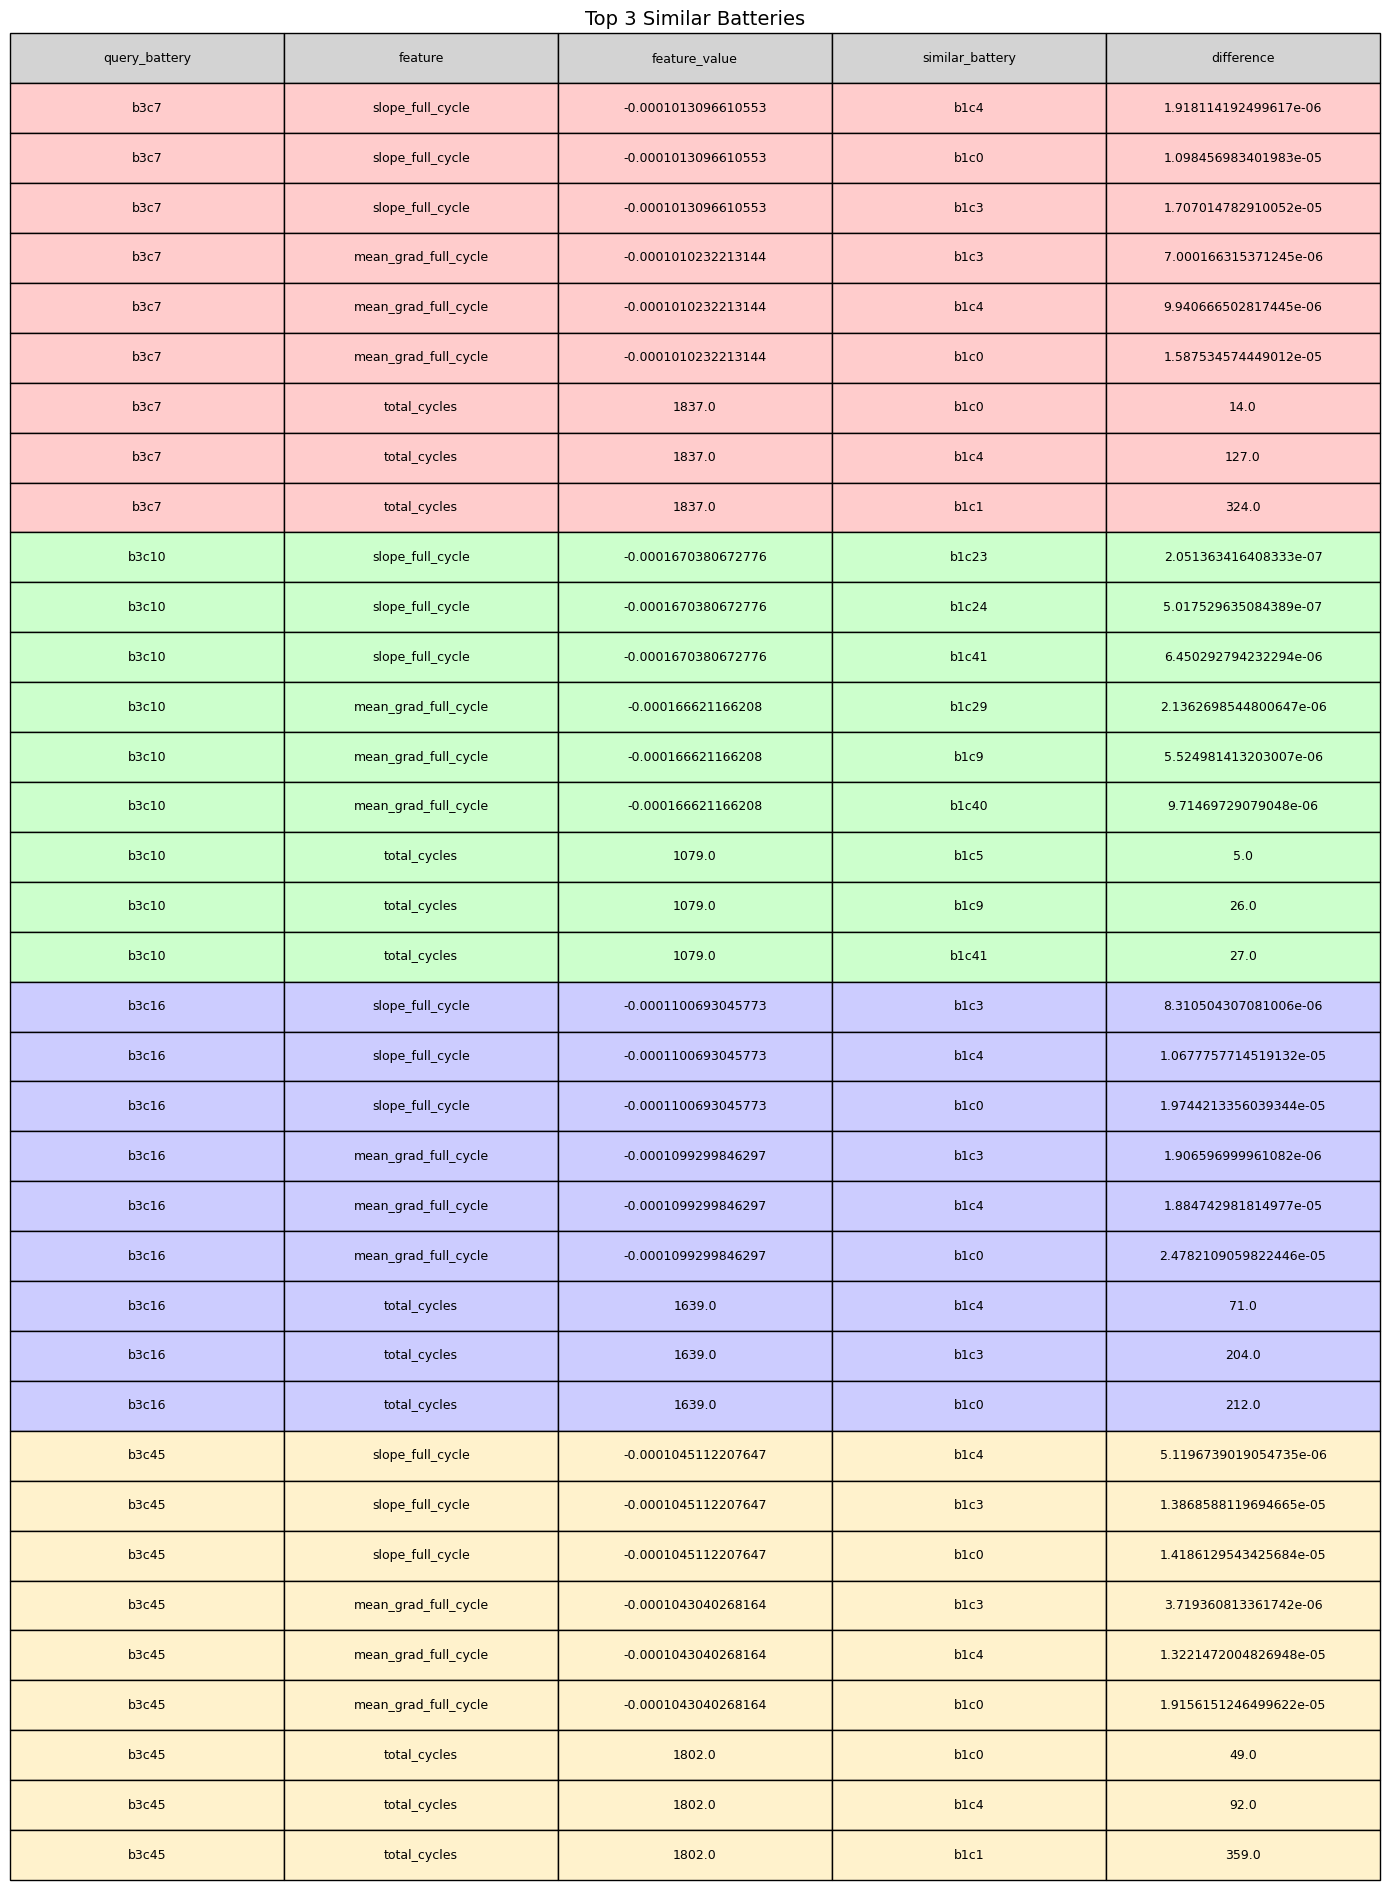

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.table import Table

# Load CSV
df = pd.read_csv("top3_similar_batteries.csv")

# Optional: assign a color per query_battery
color_map = {
    name: color for name, color in zip(
        df['query_battery'].unique(),
        ['#FFCCCC', '#CCFFCC', '#CCCCFF', '#FFF2CC', '#E0CCFF']
    )
}

def plot_colored_table(df, title="Top 3 Similar Batteries"):
    fig, ax = plt.subplots(figsize=(14, min(0.5 * len(df) + 1, 25)))
    ax.set_axis_off()

    table = Table(ax, bbox=[0, 0, 1, 1])
    n_rows, n_cols = df.shape
    width, height = 1.0 / n_cols, 1.0 / (n_rows + 1)

    # Header row
    for i, col in enumerate(df.columns):
        table.add_cell(0, i, width, height, text=col, loc='center', facecolor='lightgrey')

    # Data rows
    for row in range(n_rows):
        row_color = color_map.get(df.iloc[row]['query_battery'], 'white')
        for col in range(n_cols):
            table.add_cell(row + 1, col, width, height,
                           text=str(df.iat[row, col]), loc='center', facecolor=row_color)

    ax.add_table(table)
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Run the table plot
plot_colored_table(df)


# Now evaluate Feature => every K => Top N

In [22]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from neo4j import GraphDatabase
from tqdm import tqdm


# ─── Load ENV ────────────────────────────────────────────────────
load_dotenv()
NEO4J_URI = os.getenv("NEO4J_URI")
NEO4J_USERNAME = os.getenv("NEO4J_USERNAME")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")

driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USERNAME, NEO4J_PASSWORD))

# ─── Constants ───────────────────────────────────────────────────
K_VALUES = [10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
TOP_N = list(range(1, 6))  # 1 to 5

# ─── Ground Truth Loading ───────────────────────────────────────
ground_truth_df = pd.read_csv("top3_similar_batteries.csv")
ground_truth = {}
for _, row in ground_truth_df.iterrows():
    key = (row["query_battery"], row["feature"])
    if key not in ground_truth:
        ground_truth[key] = []
    ground_truth[key].append(row["similar_battery"])
    print("appended", row["similar_battery"], "to", key)
print(ground_truth)

appended b1c4 to ('b3c7', 'slope_full_cycle')
appended b1c0 to ('b3c7', 'slope_full_cycle')
appended b1c3 to ('b3c7', 'slope_full_cycle')
appended b1c3 to ('b3c7', 'mean_grad_full_cycle')
appended b1c4 to ('b3c7', 'mean_grad_full_cycle')
appended b1c0 to ('b3c7', 'mean_grad_full_cycle')
appended b1c0 to ('b3c7', 'total_cycles')
appended b1c4 to ('b3c7', 'total_cycles')
appended b1c1 to ('b3c7', 'total_cycles')
appended b1c23 to ('b3c10', 'slope_full_cycle')
appended b1c24 to ('b3c10', 'slope_full_cycle')
appended b1c41 to ('b3c10', 'slope_full_cycle')
appended b1c29 to ('b3c10', 'mean_grad_full_cycle')
appended b1c9 to ('b3c10', 'mean_grad_full_cycle')
appended b1c40 to ('b3c10', 'mean_grad_full_cycle')
appended b1c5 to ('b3c10', 'total_cycles')
appended b1c9 to ('b3c10', 'total_cycles')
appended b1c41 to ('b3c10', 'total_cycles')
appended b1c3 to ('b3c16', 'slope_full_cycle')
appended b1c4 to ('b3c16', 'slope_full_cycle')
appended b1c0 to ('b3c16', 'slope_full_cycle')
appended b1c3 to

🔋 Processing batteries: 100%|██████████| 4/4 [01:09<00:00, 17.36s/it]


✅ Saved to ranking_results.csv


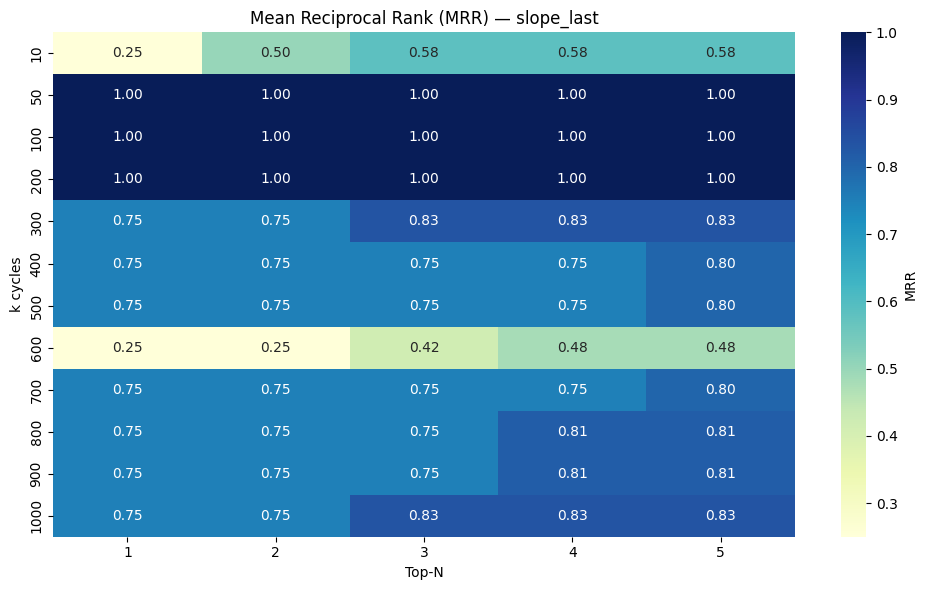

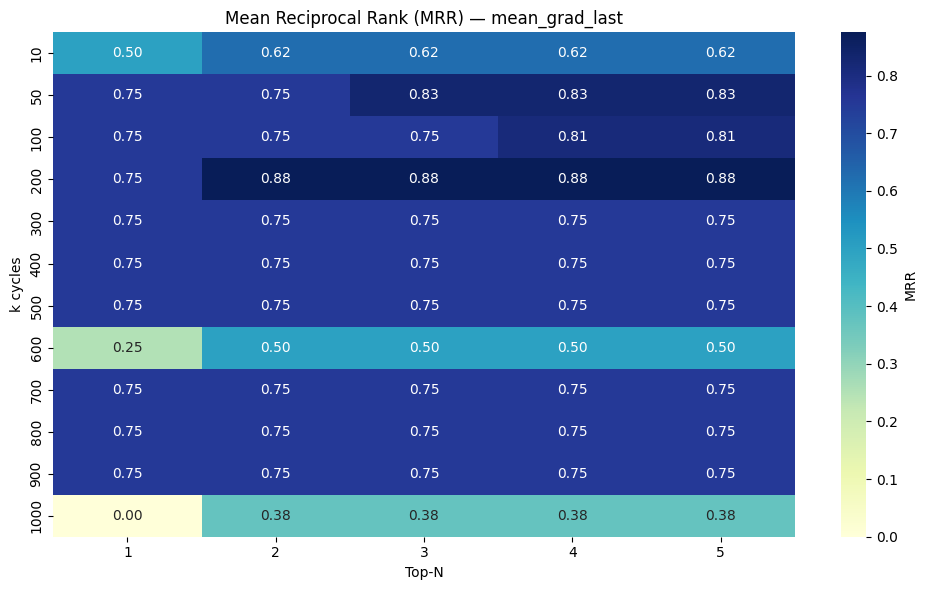

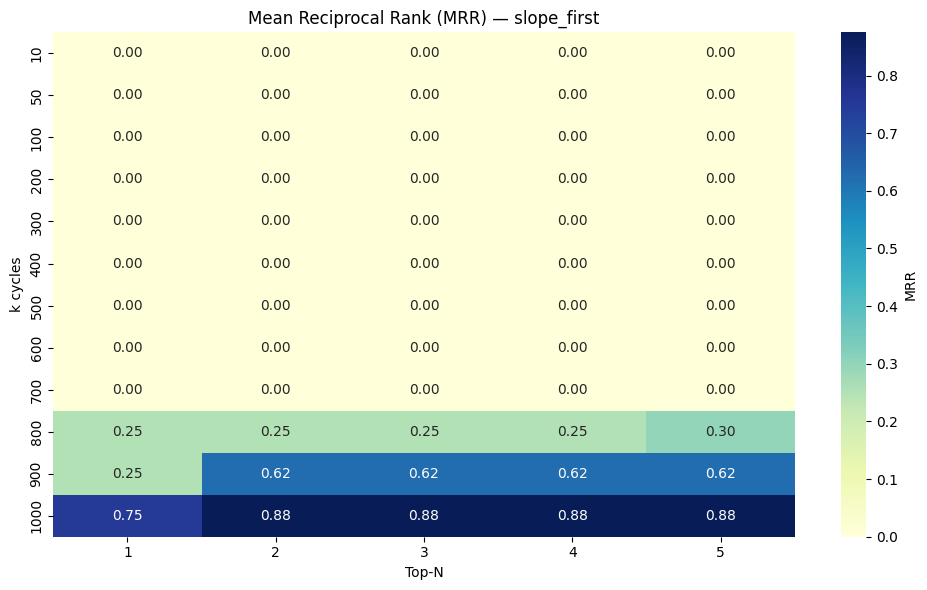

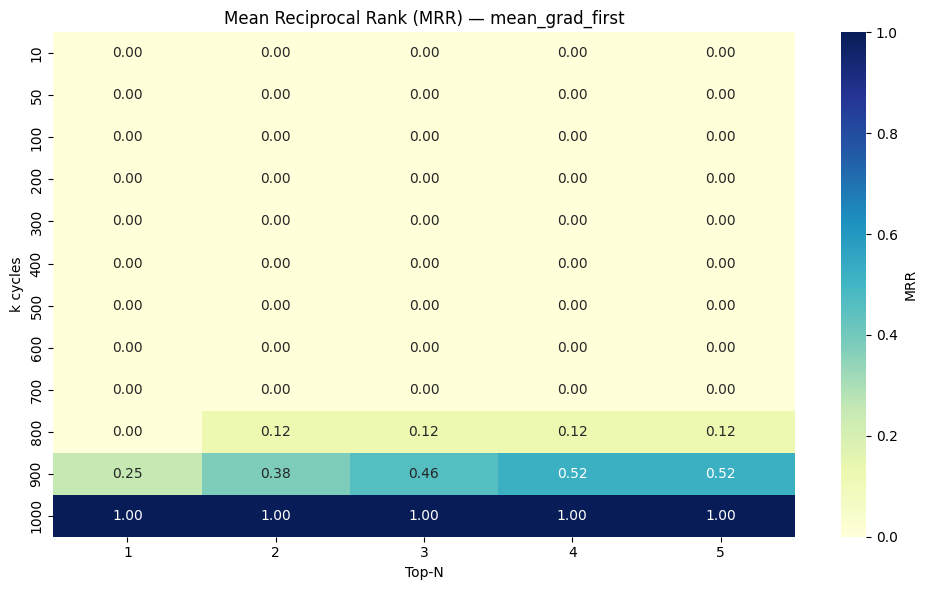

In [23]:
def map_feature_to_ground_truth_key(full_feature_name):
    if full_feature_name.startswith("slope_"):
        return "slope_full_cycle"
    elif full_feature_name.startswith("mean_grad_"):
        return "mean_grad_full_cycle"
    elif full_feature_name == "total_cycles":
        return "total_cycles"
    else:
        return full_feature_name  # fallback


# ─── Feature Extraction ──────────────────────────────────────────
def extract_features_from_sample_battery_from_text(file_text: str):
    q_d_n_values = [float(line.strip().rstrip(',')) for line in file_text.splitlines() if line.strip()]
    q_d_n_array = np.array(q_d_n_values)
    trimmed_q_d_n = np.trim_zeros(q_d_n_array, 'b')
    total_cycles = len(trimmed_q_d_n)
    features = {}

    for k in K_VALUES:
        if total_cycles > k:
            slope_last = (trimmed_q_d_n[-1] - trimmed_q_d_n[-k]) / k
            grad_last = np.gradient(trimmed_q_d_n[-k:], 1)
            mean_grad_last = float(np.mean(grad_last))
        else:
            slope_last = np.nan
            mean_grad_last = np.nan

        features[f'slope_last_{k}_cycles'] = slope_last
        features[f'mean_grad_last_{k}_cycles'] = mean_grad_last

        if total_cycles > k:
            slope_first = (trimmed_q_d_n[k-1] - trimmed_q_d_n[0]) / k
            grad_first = np.gradient(trimmed_q_d_n[:k], 1)
            mean_grad_first = float(np.mean(grad_first))
        else:
            slope_first = np.nan
            mean_grad_first = np.nan

        features[f'slope_first_{k}_cycles'] = slope_first
        features[f'mean_grad_first_{k}_cycles'] = mean_grad_first

    features['total_cycles'] = total_cycles
    return features

# ─── Neo4j Query ────────────────────────────────────────────────
def query_top_n(feature, value, N):
    query = f"""
    MATCH (b:Battery)
    WHERE b.{feature} IS NOT NULL
    RETURN b.battery_id AS battery_id, abs(b.{feature} - $val) AS diff
    ORDER BY diff ASC
    LIMIT $N
    """
    with driver.session() as session:
        result = session.run(query, val=value, N=N)
        return [record['battery_id'] for record in result]
# ─── Main Loop ───────────────────────────────────────────────────
results = []

for path in tqdm(battery_paths, desc="🔋 Processing batteries"):
    battery_id = os.path.basename(path).replace(".txt", "")
    with open(path, 'r') as f:
        file_text = f.read()
    features = extract_features_from_sample_battery_from_text(file_text)

    feature_items = [
        (k, v) for k, v in features.items()
        if "total_cycles" not in k and not pd.isna(v)
    ]

    for full_feature_name, value in tqdm(feature_items, leave=False, desc=f"📐 {battery_id} features"):
        parts = full_feature_name.split("_")
        if parts[0] == "slope":
            feature_type = "slope_" + parts[1]
        elif parts[0] == "mean":
            feature_type = "mean_grad_" + parts[2]
        k = int(parts[-2])

        general_feature = map_feature_to_ground_truth_key(full_feature_name)
        gt_key = (battery_id, general_feature)
        gt_ids = ground_truth[gt_key]

        for N in TOP_N:
            top_n_ids = query_top_n(full_feature_name, value, N)

            matched_ranks = [top_n_ids.index(gt_id) + 1 for gt_id in gt_ids if gt_id in top_n_ids]

            if matched_ranks:
                best_rank = min(matched_ranks)
                rr = 1 / best_rank
            else:
                best_rank = 0
                rr = 0

            results.append({
                "battery_id": battery_id,
                "feature_type": feature_type,
                "k": k,
                "N": N,
                "rank": best_rank,
                "reciprocal_rank": rr
            })


# ─── Save CSV ────────────────────────────────────────────────────
df = pd.DataFrame(results)
df.to_csv("ranking_results.csv", index=False)
print("✅ Saved to ranking_results.csv")

# ─── Plot Heatmaps ───────────────────────────────────────────────
for ft in df["feature_type"].unique():
    subset = df[df["feature_type"] == ft]

    # Plot MRR
    mrr_data = subset.groupby(["k", "N"])["reciprocal_rank"].mean().unstack()
    plt.figure(figsize=(10, 6))
    sns.heatmap(mrr_data, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={"label": "MRR"})
    plt.title(f"Mean Reciprocal Rank (MRR) — {ft}")
    plt.xlabel("Top-N")
    plt.ylabel("k cycles")
    plt.tight_layout()
    plt.savefig(f"heatmap_mrr_{ft}.png")
    plt.show()

    # # Plot Mean Rank
    # rank_data = subset.groupby(["k", "N"])["rank"].mean().unstack()
    # plt.figure(figsize=(10, 6))
    # sns.heatmap(rank_data, annot=True, fmt=".2f", cmap="Reds", cbar_kws={"label": "Avg Rank"})
    # plt.title(f"Mean Rank — {ft}")
    # plt.xlabel("Top-N")
    # plt.ylabel("k cycles")
    # plt.tight_layout()
    # plt.savefig(f"heatmap_rank_{ft}.png")
    # plt.show()


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown

# Load results
df = pd.read_csv("ranking_results.csv")
df = df[df["feature_type"].isin(["slope_first", "slope_last"])]

# Group stats
summary = (
    df.groupby(["feature_type", "k", "N"])
    .agg(mrr=("reciprocal_rank", "mean"), avg_rank=("rank", "mean"))
    .reset_index()
)

# Use these specific values for k
custom_k_values = [10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

@interact(k=Dropdown(options=custom_k_values, description="k"))
def plot_k_comparison(k):
    slope_first = summary[(summary["feature_type"] == "slope_first") & (summary["k"] == k)]
    slope_last = summary[(summary["feature_type"] == "slope_last") & (summary["k"] == k)]

    Ns = sorted(slope_first["N"].unique())

    plt.figure(figsize=(10, 5))
    plt.plot(Ns, slope_first["mrr"], label="slope_first", marker="o")
    plt.plot(Ns, slope_last["mrr"], label="slope_last", marker="o")
    plt.xticks(Ns)
    plt.title(f"MRR Comparison (k={k})")
    plt.xlabel("Top-N")
    plt.ylabel("Mean Reciprocal Rank")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


interactive(children=(Dropdown(description='k', options=(10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, …